### Step 1. Open the data file and study the general information. 

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

In [2]:
# File information
car_sales = pd.read_csv('vehicles_us.csv')
display(car_sales.head())
display(car_sales.info())

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


None

In [3]:
# Rate of missing values in each column to the whole dataset
((car_sales.isna().sum()/len(car_sales))*100).round(2)

price            0.00
model_year       7.02
model            0.00
condition        0.00
cylinders       10.21
fuel             0.00
odometer        15.32
transmission     0.00
type             0.00
paint_color     17.99
is_4wd          50.37
date_posted      0.00
days_listed      0.00
dtype: float64

### Step 2. Data Preprocessing

In [4]:
# Change date_posted datatype to datetime
car_sales['date_posted'] = pd.to_datetime(car_sales['date_posted'])

# Fill NaNs in cylinders column with the mean of cars of the same model
car_sales['cylinders'] = (
                          car_sales
                          .groupby('model' , sort=False)['cylinders']
                          .apply(lambda x: x.fillna(x.mean()))
                          )
car_sales['cylinders'] = car_sales['cylinders'].round(0).astype(int)

# Filled the NaNs in the 'paint_color' column with the mode of the grouped models.
car_sales['paint_color'] = (
                            car_sales
                            .groupby('model', sort=False)['paint_color']
                            .apply(lambda x: x.fillna(x.mode().iloc[0]))
                            )

# Fill the NaNs in is_4wd column with zeros since the column contains either 1 or 0
car_sales['is_4wd'].fillna(0, inplace=True)
car_sales['is_4wd'] = car_sales['is_4wd'].astype(int)

In [5]:
# Fill NaNs in model_year column with the median of cars of the same model
car_sales['model_year'] = (
    car_sales
    .groupby('model', sort=False)['model_year']
    .apply(lambda x: x.fillna(x.median()))
    .astype(int)
    )

# Replace model_year of model 'ford f-150' with the median of cars of the same model
car_sales.loc[car_sales['model_year'] == 1929, 'model_year'] = 2011

In [6]:
# Surpress the 'RuntimeWarning: Mean of empty slice' warning that filling the NaNs in odometer column generates
warnings.filterwarnings(action='ignore', message='Mean of empty slice')

# Fill NaNs in odometer column with the median of cars of the same model year and condition
car_sales['odometer'] = (
                        car_sales
                        .groupby(['model_year', 'condition'], sort=False)['odometer']
                        .apply(lambda x: x.fillna(x.median()))
                        )

# Drop 6 NaNs left after filling NaNs in the column with median of cars of the same model year and condition 
car_sales.dropna(subset=['odometer'], inplace=True)

In [7]:
# Check for duplicates
len(car_sales[car_sales.duplicated()])

0

### Step 3. Data Manipulation

In [8]:
# Add year_posted, vehicle_age and mileage per year columns to the dataset
car_sales['date_posted'] = pd.to_datetime(car_sales['date_posted'], format='%Y-%m-%d')
car_sales['year_posted'] = car_sales['date_posted'].dt.year
car_sales['vehicle_age'] = car_sales['year_posted'] - car_sales['model_year']
car_sales['mileage_per_year'] = car_sales['odometer'] / car_sales['vehicle_age']

# Replace the infs in mileage_per_year column with the respective value in odometer column since the vehicle age is 0
not_inf_mileage = car_sales.query('mileage_per_year != "inf"')
car_sales['new_mileage_per_year'] = (
                                    car_sales['mileage_per_year']
                                    .where(car_sales['mileage_per_year']
                                    .isin(not_inf_mileage['mileage_per_year']), car_sales['odometer'])
                                    .round(2)
                                    )
del car_sales['mileage_per_year']
car_sales['new_mileage_per_year'].fillna(0, inplace=True)
car_sales.rename(columns={'new_mileage_per_year': 'mileage'}, inplace=True)

# Replace the 'inf' in mileage column with 0 since their odometer is 0
car_sales['mileage'].replace([np.inf, -np.inf], 0, inplace=True)

In [9]:
# Change the values in the condition column to numeric
mapping = {'new': 5, 'like new': 4, 'excellent': 3, 'good': 2, 'fair': 1, 'salvage': 0}
car_sales['condition'] = car_sales['condition'].apply(lambda x: mapping[x])

In [10]:
car_sales.head(2)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,year_posted,vehicle_age,mileage
0,9400,2011,bmw x5,2,6,gas,145000.0,automatic,SUV,black,1,2018-06-23,19,2018,7,20714.29
1,25500,2011,ford f-150,2,6,gas,88705.0,automatic,pickup,white,1,2018-10-19,50,2018,7,12672.14


### Exploratory Data Analysis

Calculate the whiskers

In [11]:
def whiskers_calculator(df, a_col):
    '''
    This function calculates the Q1, Q3, IQR, and upper and lower whiskers for the quantitative columns.
    '''

    a_dict = {}
    Q1 = df[a_col].quantile(0.25)
    Q3 = df[a_col].quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = round((Q3 + 1.5 * IQR), 2)
    lower_whisker = round((Q1 - 1.5 * IQR), 2)
    a_dict[a_col] = upper_whisker
    display(a_dict)

In [12]:
# Creating a dictionary with each column and its upper whisker
outlier_columns = ['price', 'vehicle_age', 'mileage', 'days_listed']

for a_col in outlier_columns:
    whiskers_calculator(car_sales, a_col)

{'price': 34592.5}

{'vehicle_age': 24.0}

{'mileage': 35872.27}

{'days_listed': 104.0}

Filter the Outliers 

In [13]:
# Filter out the outliers 
filtered1 = car_sales.query('4000 <= price <= 34592.5 and vehicle_age <= 24.0')
filtered2 = filtered1.query('mileage <= 35872.27')
good_ads = filtered2.query('10 <= days_listed <= 104.0')

Compare the unfiltered and filtered data

In [14]:
def histogram_comparison(df1, df2, metric):
    '''
    
    '''
    df1[metric].hist(bins=30)
    df2[metric].hist(bins=30)
    plt.title('Comparing the Filtered and Unfiltered Data for {}'.format(metric))
    plt.xlabel('{}'.format(metric))
    plt.ylabel('counts')
    plt.show()

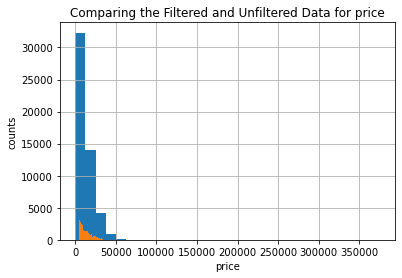

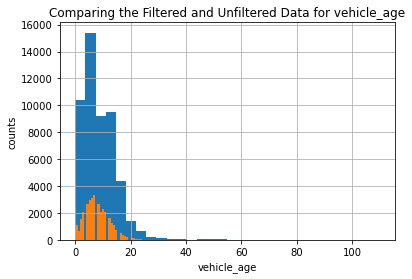

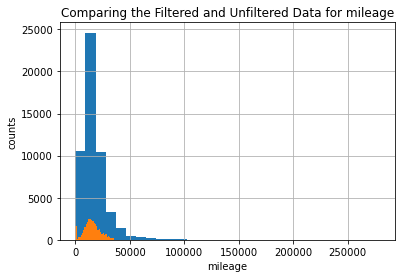

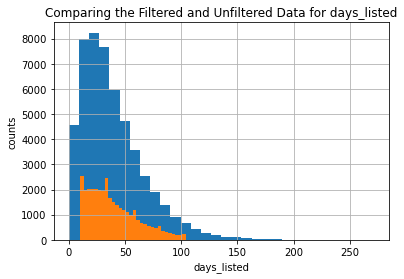

In [15]:
for a_col in outlier_columns:
    histogram_comparison(car_sales, good_ads, a_col)

#### Number of ads and average price for each type of vehicle

In [16]:
car_sales.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,year_posted,vehicle_age,mileage
0,9400,2011,bmw x5,2,6,gas,145000.0,automatic,SUV,black,1,2018-06-23,19,2018,7,20714.29
1,25500,2011,ford f-150,2,6,gas,88705.0,automatic,pickup,white,1,2018-10-19,50,2018,7,12672.14
2,5500,2013,hyundai sonata,4,4,gas,110000.0,automatic,sedan,red,0,2019-02-07,79,2019,6,18333.33
3,1500,2003,ford f-150,1,8,gas,193850.0,automatic,pickup,white,0,2019-03-22,9,2019,16,12115.62
4,14900,2017,chrysler 200,3,4,gas,80903.0,automatic,sedan,black,0,2019-04-02,28,2019,2,40451.50


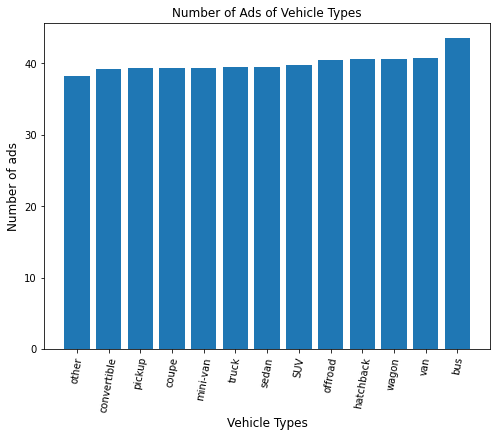

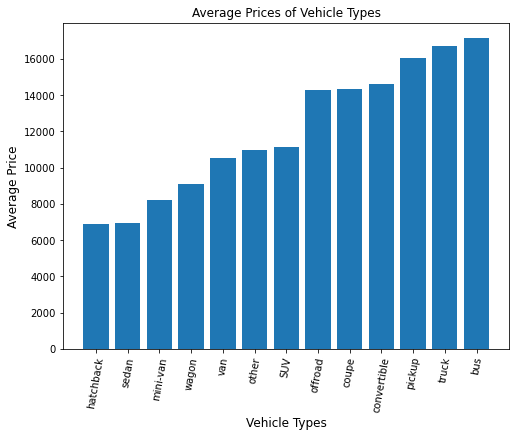

In [17]:
#Analyze the average number of ads and the average price for each type of vehicle. Plot a graph showing the
#dependence of the number of ads on the vehicle type. Select the two types with the greatest number of ads
model_dayslisted = (
                    car_sales
                    .groupby('type', as_index=False)['days_listed']
                    .mean()
                    .sort_values(by='days_listed',ascending=True)
                    )
model_dayslisted['days_listed'] = model_dayslisted['days_listed'].round(2)

model_price = (
               car_sales
               .groupby('type', as_index=False)['price']
               .mean()
               .sort_values(by='price',ascending=True)
               )
model_price['price'] = model_price['price'].round(2)


plt.figure(figsize=(8,6))
plt.bar(model_dayslisted['type'], model_dayslisted['days_listed'])
plt.title('Number of Ads of Vehicle Types')
plt.xlabel('Vehicle Types', size=12)
plt.ylabel('Number of ads', size=12)
plt.xticks(rotation=80)
plt.show()

plt.figure(figsize=(8,6))
plt.bar(model_price['type'], model_price['price'])
plt.title('Average Prices of Vehicle Types')
plt.xlabel('Vehicle Types', size=12)
plt.ylabel('Average Price', size=12)
plt.xticks(rotation=80)
plt.show()

In [18]:
model_df = pd.merge(model_price, model_dayslisted, on='type')
display(model_df.head())
display('The correlation between number of days listed of a vehicle type and its price is {}'
        .format(round(model_df['days_listed'].corr(model_df['price']), 3)))

,type,price,days_listed
0,hatchback,6868.51,40.53
1,sedan,6965.76,39.43
2,mini-van,8193.18,39.40
3,wagon,9088.13,40.57
4,van,10546.94,40.70


'The correlation between number of days listed of a vehicle type and its price is 0.204'

<b>Conclusion</b>

There is a small positive correlation (0.204) between the price of a vehicle and the average number of days listed.

#### Factors that Impact Vehicle Price - Age, Mileage, Condition

##### SUVs

In [19]:
# Create a pivot table for SUVs
suv_price_dependency = (
                good_ads
                .query('type == "SUV"')
                .pivot_table(index='model', values=['price', 'vehicle_age', 'mileage', 'condition'], aggfunc='mean')
                .reset_index()
                )
columns = ['price', 'vehicle_age', 'mileage', 'condition']
for col in columns:
    suv_price_dependency[col] = suv_price_dependency[col].round(0).astype(int)

display(suv_price_dependency.head())

# Create a pivot table for trucks
truck_price_dependency = (
                good_ads
                .query('type == "truck"')
                .pivot_table(index='model', values=['price', 'vehicle_age', 'mileage', 'condition'], aggfunc='mean')
                .reset_index()
                )

columns = ['price', 'vehicle_age', 'mileage', 'condition']
for col in columns:
    truck_price_dependency[col] = truck_price_dependency[col].round(0).astype(int)

display(truck_price_dependency.head())

,model,condition,mileage,price,vehicle_age
0,acura tl,2,11967,4950,11
1,bmw x5,3,13658,11613,9
2,buick enclave,3,19015,12357,6
3,cadillac escalade,3,14013,13132,10
4,chevrolet cruze,2,26,4450,6


,model,condition,mileage,price,vehicle_age
0,bmw x5,3,14873,8966,10
1,buick enclave,4,24962,15499,2
2,cadillac escalade,3,14813,11733,10
3,chevrolet colorado,3,14280,17217,5
4,chevrolet corvette,2,2981,14995,19


I generated a pivot table from the earlier filtered data and querried the data to generate rows that contain only rows whose type is SUV. The pivot table contains the condition of the car, mileage, price, and vehicle's age. I also rounded each column to zero and changed their types to integer for ease of manipulation.

-0.29445673136367473

-0.3996867875160479

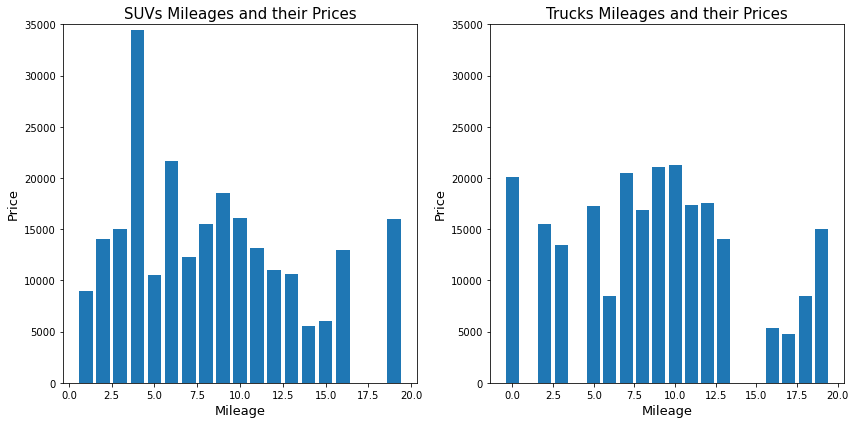

In [20]:
#Correlation between vehicle age and price  in SUVs and Trucks
display(suv_price_dependency['price'].corr(suv_price_dependency['vehicle_age']))
display(truck_price_dependency['price'].corr(truck_price_dependency['vehicle_age']))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].bar(suv_price_dependency['vehicle_age'], suv_price_dependency['price'])
ax[0].set_title('SUVs Mileages and their Prices', fontsize=15)
ax[0].set_ylim(0, 35000)
ax[0].set_xlabel("Mileage", fontsize=13)
ax[0].set_ylabel("Price", fontsize=13)

ax[1].bar(truck_price_dependency['vehicle_age'], truck_price_dependency['price'])
ax[1].set_title("Trucks Mileages and their Prices", fontsize=15)
ax[1].set_ylim(0, 35000)
ax[1].set_xlabel("Mileage", fontsize=13)
ax[1].set_ylabel("Price", fontsize=13)
fig.tight_layout()
plt.show()

##### Conclusion

Here, with the correlation coefficient = -0.282, the negative correlation between a vehicle's age and its price means that the higher the age of a vehicle, the lower the price of the vehicle vice versa.

0.31349205572801975

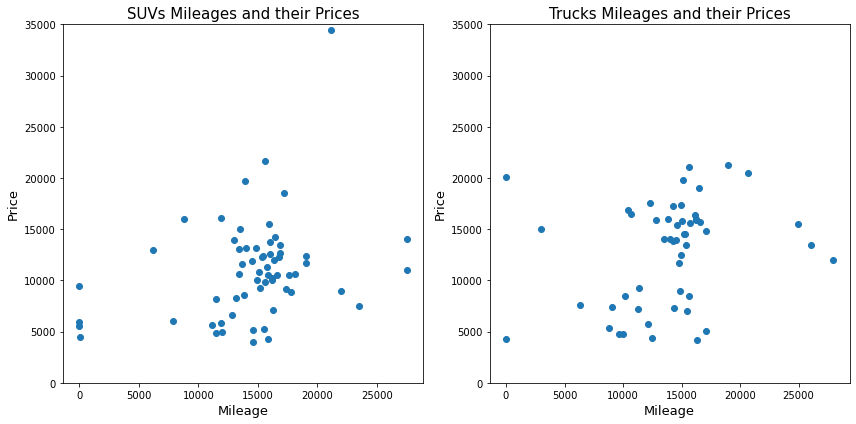

In [21]:
#Correlation between mileage and price  in SUVs and Trucks
display(suv_price_dependency['price'].corr(suv_price_dependency['mileage']))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].scatter(x = suv_price_dependency['mileage'], y = suv_price_dependency['price'])
ax[0].set_title('SUVs Mileages and their Prices', fontsize=15)
ax[0].set_ylim(0, 35000)
ax[0].set_xlabel("Mileage", fontsize=13)
ax[0].set_ylabel("Price", fontsize=13)

ax[1].scatter(x = truck_price_dependency['mileage'], y = truck_price_dependency['price'])
ax[1].set_title("Trucks Mileages and their Prices", fontsize=15)
ax[1].set_ylim(0, 35000)
ax[1].set_xlabel("Mileage", fontsize=13)
ax[1].set_ylabel("Price", fontsize=13)
fig.tight_layout()
plt.show()

##### Conclusion

Here, there is a positive correlation coefficient. Also from the graph, the price tends to slightly increase with increase in mileage. This means that cars riden for longer periods of time have slightly higher average prices than ones with lower mileage.

0.30070441750238697

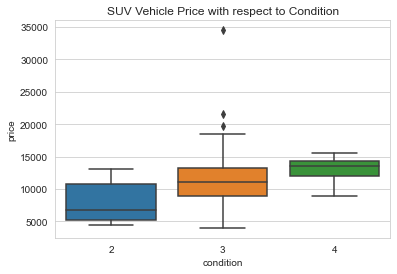

In [22]:
#Correlation between condition and price in SUVs
sns.set_style('whitegrid')
(sns.boxplot(x='condition', y='price', data=suv_price_dependency)
    .set_title('SUV Vehicle Price with respect to Condition'))
display(suv_price_dependency['price'].corr(suv_price_dependency['condition']))

##### Conclusion

Here, there is a positive correlation coefficient. Also from the graph, more cars with condition 3 have slightly higher average prices than cars with condition 2.

##### Trucks

In [23]:
outlier_columns

['price', 'vehicle_age', 'mileage', 'days_listed']

In [24]:
# Create a pivot table for trucks
truck_data = good_ads.query('type == "truck"')
truck_price_dependency = (
                truck_data
                .pivot_table(index='model', values=['price', 'vehicle_age', 'mileage', 'condition'], aggfunc='mean')
                .reset_index()
                )

for a_col in truck_price_dependency.drop('model', axis=1).columns.tolist():
    truck_price_dependency[a_col] = truck_price_dependency[a_col].round(0).astype(int)

display(truck_price_dependency.head())

,model,condition,mileage,price,vehicle_age
0,bmw x5,3,14873,8966,10
1,buick enclave,4,24962,15499,2
2,cadillac escalade,3,14813,11733,10
3,chevrolet colorado,3,14280,17217,5
4,chevrolet corvette,2,2981,14995,19


-0.3996867875160479

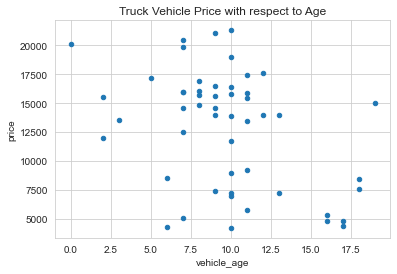

In [25]:
#Correlation between vehicle's age and price in Trucks
(
    truck_price_dependency
    .plot(kind='scatter', x='vehicle_age', y='price', grid=True, title='Truck Vehicle Price with respect to Age')
)
display(truck_price_dependency['price'].corr(truck_price_dependency['vehicle_age']))

##### Conclusion

The correlation coefficient is -0.24. This implies that as the vehicle age increases, the price decreases.

0.26086531731685836

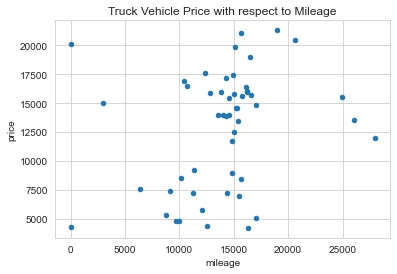

In [26]:
#Correlation between mileage and price in Trucks
(
    truck_price_dependency
    .plot(kind='scatter', x='mileage', y='price', grid=True, title='Truck Vehicle Price with respect to Mileage')
)
truck_price_dependency['price'].corr(truck_price_dependency['mileage'])

##### Conclusion

Here, the correlation coefficient is 0.43. This implies that the price slightly increases with an increase in mileage.

-0.28232243439870097

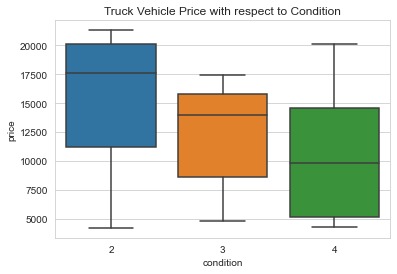

In [27]:
#Correlation between condition and price in Trucks
sns.set_style('whitegrid')
(
    sns
    .boxplot(x='condition', y='price', data=truck_price_dependency)
    .set_title('Truck Vehicle Price with respect to Condition')
)
truck_price_dependency['price'].corr(truck_price_dependency['condition'])

##### Conclusion

Here, the correlation coefficient is -0.28. This implies that the average condition of a truck negatively affects the price.

<a id='price_impact2'></a> 

####  Factors that impact price. Paint color, Transmission

We only consider SUVs and Truck with `days_listed` of at least 50 as our case study.

In [28]:
suv_models = (
            good_ads
            .query('type == "SUV"')
            .groupby('model', as_index=False)
            .agg({'days_listed': 'sum', 'transmission': 'first', 'paint_color': 'first', 'price': 'mean'})
            )
suv_models = suv_models.query('days_listed >= 50')
suv_models['price'] = suv_models['price'].round(2)
suv_models.head()

,model,days_listed,transmission,paint_color,price
0,acura tl,140,automatic,grey,4950.00
1,bmw x5,7677,automatic,black,11613.08
2,buick enclave,8139,automatic,brown,12357.04
3,cadillac escalade,9300,automatic,black,13132.47
5,chevrolet equinox,14996,automatic,grey,10561.35


#### Boxplot for price against transmission type for SUVs

Text(0.5, 1.0, 'SUV Vehicle Price with respect to Transmission')

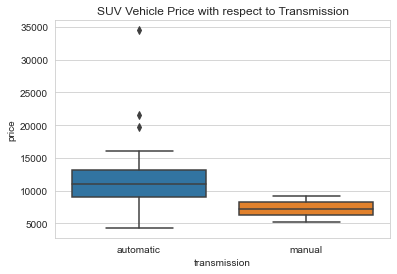

In [29]:
sns.set_style("whitegrid")
sns.boxplot(x='transmission', y='price', data=suv_models).set_title('SUV Vehicle Price with respect to Transmission')

##### Conclusion

Above is the boxplots of 'transmission' against 'price' of SUVs. 

**Manual** SUVs boxplot shows that all SUVs with manual transmission all fall between 5000 to 9800 price range. No huge dispersion or any outliers.

**Automatic** SUVs boxplot shows that there are some outlier. The first 50% price range almost coincides with the other 50% price range but with a slight difference. The first 50% of the SUVs are priced between 4800 and 12,000 while the other 50% are priced between 12,000 and 35,000. The upper whisker is around 16,000

##### Boxplot charts for price against color for SUVs

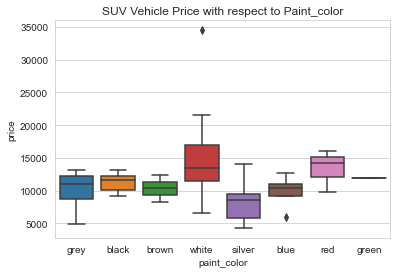

In [30]:
sns.set_style("whitegrid")
box_color = (
            sns
            .boxplot(x='paint_color', y='price', data=suv_models)
            .set_title('SUV Vehicle Price with respect to Paint_color')
            )

##### Conclusion

Above is the boxplots of 'paint_color' against 'price' of SUVs.

The boxplot shows that only the **Brown** colored car is normally distributed because their medians lie in the middle of their boxes. This implies that there are some level of skewness in the dataset for other colors.

Only **white** and **blue** cars have outliers - upper and lower outliers respectively.

**Black** has its median closer to the 3rd quartile showing that it is negatively skewed. This also means that most of its prices are between 9,000 and 12,900.

SUVs with the most variability in prices are **white**, **red**, **grey**, and **silver**. This can be seen from the length of their boxes. Although most of their prices are distributed below their median prices.

**Blue** SUVs have positively skewed boxplot which means that it has most of its prices above the 50% of its distribution. This upper 50% is distributed within 11,000 and 13,500. The lower 50% all fall in the range of price below 10,500

**Silver** SUVs in this category cost between 4,000 and 14,500. 25% cost between 4,000 and 5,500, the next 25% cost between 5,500 and 9,500 while the last 50% of them cost btw 9,500 and 14,500 for which half of the prices range btw 9,500 and 9,900.

**Green** colored SUVs have the least variabilty because the prices for the car(s) fall in 12,000 which means that all prices coincide.

In [31]:
#Trucks
truck_models = (
            good_ads
            .query('type == "SUV"')
            .groupby('model', as_index=False)
            .agg({'days_listed': 'sum', 'transmission': 'first', 'paint_color': 'first', 'price': 'mean'})
            )
truck_models = truck_models.query('days_listed >= 50')
truck_models['price'] = truck_models['price'].round(2)
truck_models.head()

,model,days_listed,transmission,paint_color,price
0,acura tl,140,automatic,grey,4950.00
1,bmw x5,7677,automatic,black,11613.08
2,buick enclave,8139,automatic,brown,12357.04
3,cadillac escalade,9300,automatic,black,13132.47
5,chevrolet equinox,14996,automatic,grey,10561.35


#### Boxplot of 'Transmission' against 'Price' of Trucks

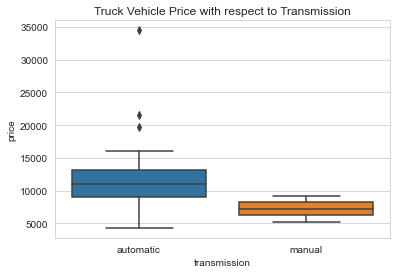

In [32]:
sns.set_style("whitegrid")
(
    sns
    .boxplot(x='transmission', y='price', data=truck_models)
    .set_title('Truck Vehicle Price with respect to Transmission')
)
plt.show()

**Conclusion**

Above is the boxplots of 'transmission' against 'price' of trucks.

**Automatic** trucks have some outliers which points to the fact that there are trucks that are priced way below other prices. From the boxplot, the distribution is skewwed to the right. The trucks in this category are priced from 4,700 to 35,000. The first 25% of automatic trucks are priced between 4,700 and 9,200, the next 25% are between 9,200 and 11,800, the next between 11,800 and 14,000, and the last 25% has the highest dispersion between 14,000 and 35000. The upper whisker starts from 16,000.

**Manual** trucks boxplot shows that all manual trucks are within a close price range (5,000 to 9,800) which is less than the highest price of automatic trucks.

#### Boxplot of `Paint_color` against `Price` of Trucks

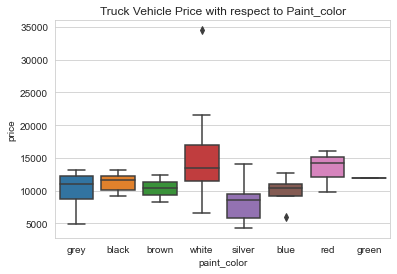

In [33]:
sns.set_style("whitegrid")
(
    sns
    .boxplot(x='paint_color', y='price', data=truck_models)
    .set_title('Truck Vehicle Price with respect to Paint_color')
)
plt.show()

##### Conclusion

Above is the boxplots of 'paint_color' against 'price' of trucks.

**Green** trucks have their prices on the same price levels of 12,200. 

**Brown** trucks are normally distributed within the range-prices of 8,500 and 13,000 unlike other trucks.

**White** trucks have the widest price range of 6,000 to 14,000 and those prices are more in the first 50% of the range than in the other 50%. The boxplot is positively skewwed and has upper outliers. **Blue** trucks also have lower outliers.

**Grey**, **Silver**, and **Red** trucks also have a wide range of price but not as wide as white trucks. 